# Dataset: Oxford Flowers 102
8,189 images

102 flower categories

Samples per class	Between 40 and 258 images

Image size	Varies (need resizing)

Format	JPEG images with a .mat split file

Avantages :

Images de haute résolution avec beaucoup de détails
Diversité de couleurs, textures et formes
Bonne taille de dataset (ni trop petit, ni trop grand)
Fond relativement homogène qui facilite l'apprentissage


Pourquoi ce dataset : Les images de fleurs sont idéales pour tester la reconstruction car elles contiennent des motifs répétitifs mais aussi des détails complexes. Le modèle devra apprendre à reconstruire les textures fines des pétales, les gradients de couleur, et les structures des fleurs.



# Modèle: ViT-Base Patch16-224
préentraîné sur ImageNet:

### Pourquoi ce modèle :

Architecture standard avec une taille de patch de 16×16 pixels (sont ensuite transformés en "tokens" (comme des mots dans un texte), que le modèle peut traiter)

Préentraîné sur un grand dataset (ImageNet: un très grand ensemble d’images avec des milliers de catégories.)

Bon équilibre entre performance et complexité

Très bien supporté par les bibliothèques comme Hugging Face


### Spécifications :

12 couches de transformer :  Le modèle passe l’information à travers 12 niveaux de traitement.

12 têtes d'attention par couche :  Chaque couche peut regarder différentes parties de l’image en parallèle pour comprendre les relations entre les éléments.

Dimension cachée de 768 :  la taille des vecteurs internes que le modèle utilise pour représenter l’information à chaque étape.

Nombre total de paramètres : ~86M

In [1]:
!pip install tensorflow

In [2]:
!pip install tf-keras

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, callbacks
import tensorflow_datasets as tfds
from transformers import TFViTModel
from skimage.metrics import structural_similarity as ssim
import time
import os

# Configuration
IMAGE_SIZE = 224  #  C’est la taille d’image attendue par ViT-Base Patch16-224, car il a été préentraîné avec cette dimension sur ImageNet
PATCH_SIZE = 16   # Taille des patchs pour ViT
BATCH_SIZE = 32   # Réduit pour éviter les problèmes de mémoire
AUTOTUNE = tf.data.AUTOTUNE
LEARNING_RATE = 1e-4 #  une bonne valeur de départ pour du fine-tuning, surtout avec des modèles préentraînés.
EPOCHS = 20
DATASET_NAME = "oxford_flowers102"
CHECKPOINT_PATH = "./checkpoints/vit_reconstruction"

2025-04-24 14:51:36.830191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745506297.014250      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745506297.066984      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Chargement et préparation du dataset

Chargement du dataset oxford_flowers102...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.W7SLQS_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.W7SLQS_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.W7SLQS_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


I0000 00:00:1745506380.230168      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Nombre total d'images: 8189
Taille des images: (None, None, 3)
Nombre total d'images: 8189
Nombre d'images d'entraînement (90%): 7370
Nombre d'images de validation (10%): 819
Taille des images (brute): (None, None, 3)


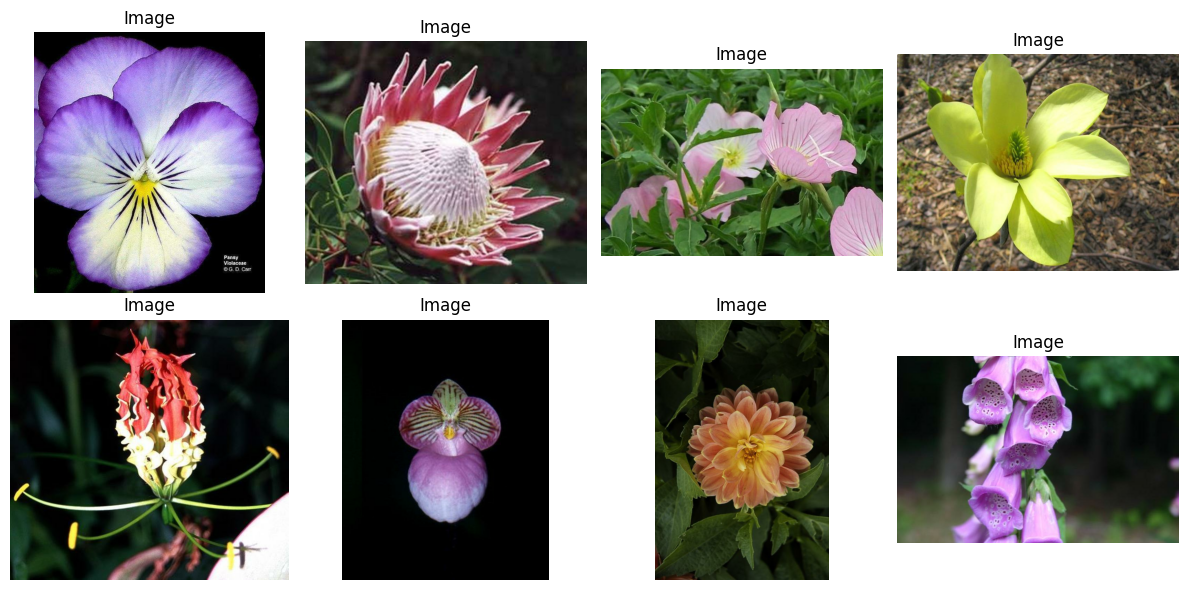

In [4]:
print(f"Chargement du dataset {DATASET_NAME}...")
ds_all = tfds.load(
    DATASET_NAME,
    split="train+validation+test",
    shuffle_files=True,
    as_supervised=True
)
# On ne garde que les images (on ignore les labels)
ds_all = ds_all.map(lambda img, label: img, num_parallel_calls=AUTOTUNE)

# Infos du dataset
ds_info = tfds.builder(DATASET_NAME).info
total_images = ds_info.splits['train'].num_examples + \
               ds_info.splits['validation'].num_examples + \
               ds_info.splits['test'].num_examples

print(f"Nombre total d'images: {total_images}")
print(f"Taille des images: {ds_info.features['image'].shape}")

# Shuffle et split manuel 90/10
ds_all = ds_all.shuffle(10000, reshuffle_each_iteration=False)
train_size = int(0.9 * total_images)

train_ds = ds_all.take(train_size)
val_ds = ds_all.skip(train_size)

# Affichage des informations du dataset
# Affichage des infos après split manuel
print(f"Nombre total d'images: {total_images}")
print(f"Nombre d'images d'entraînement (90%): {train_size}")
print(f"Nombre d'images de validation (10%): {total_images - train_size}")
print(f"Taille des images (brute): {ds_info.features['image'].shape}")


# Display a few images (sans labels car on les a retirés)
plt.figure(figsize=(12, 6))

for i, img in enumerate(train_ds.take(8)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title("Image")
    plt.axis("off")

plt.tight_layout()
plt.show()



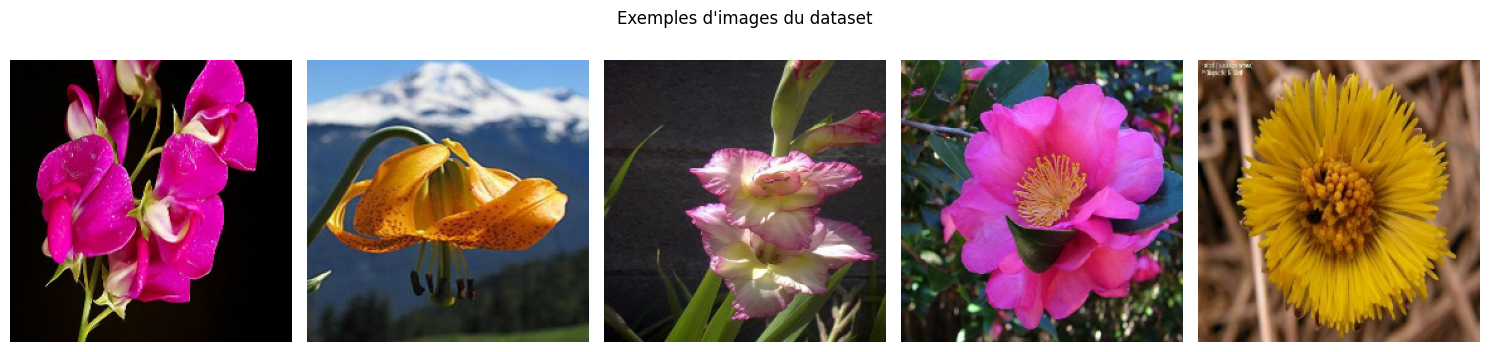

In [5]:


def preprocess_image(image):
    """
    Prétraite les images pour le modèle ViT:
    1. Redimensionne à la taille attendue par ViT (224x224)
    2. Normalise les valeurs des pixels entre 0 et 1
    3. Utilise l'image originale comme cible pour la reconstruction
    """
   # Gestion des images en niveaux de gris ou avec plus de 3 canaux
    if tf.shape(image)[-1] != 3:
        image = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))


    # Redimensionnement et normalisation
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    # Pour la tâche de reconstruction, l'entrée et la sortie sont les mêmes image
    return image, image

# Préparation des datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Optimisation des performances
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Visualisation d'exemples d'images
def visualize_dataset_samples(dataset, num_images=5):
    """Affiche quelques exemples d'images du dataset."""
    plt.figure(figsize=(15, 4))
    for i, (image, _) in enumerate(dataset.unbatch().take(num_images)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Exemples d'images du dataset")
    plt.show()

visualize_dataset_samples(train_ds)

# Implémentation des stratégies de masquage

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

def random_masking(images, masking_ratio=0.5):
    batch_size = tf.shape(images)[0]
    height = tf.shape(images)[1]
    width = tf.shape(images)[2]
    num_channels = tf.shape(images)[3]

    h, w = height // PATCH_SIZE, width // PATCH_SIZE
    num_patches = h * w # Le nombre total de patchs dans l'image
    #calcule combien de patchs seront masqués, en fonction du masking_ratio.
    num_masked = tf.cast(masking_ratio * tf.cast(num_patches, tf.float32), tf.int32)

    # Masque initial pour tout le batch: crée une matrice de zéros de forme (batch_size, num_patches)
    mask = tf.zeros((batch_size, num_patches), dtype=tf.float32)

    def mask_single_image(i, mask):
        # Crée une liste d’indices [0, 1, ..., num_patches-1]
        random_indices = tf.random.shuffle(tf.range(num_patches))[:num_masked]
        # Crée un vecteur de même taille que random_indices rempli de 1.0
        updates = tf.ones_like(random_indices, dtype=tf.float32)
        indices = tf.stack([tf.fill([num_masked], i), random_indices], axis=1)  
        return tf.tensor_scatter_nd_update(mask, indices, updates) # modifier uniquement les cases choisies, sans affecter les autres.

    for i in tf.range(batch_size):
        mask = mask_single_image(i, mask)
        
    # Le masque est redimensionné pour qu’il corresponde à la taille de l’image
    mask = tf.reshape(mask, (batch_size, h, w, 1))
    mask = tf.image.resize(mask, (height, width), method='nearest')
    # tf.repeat() du masque est utilisé pour qu'il ait le même nombre de canaux que l'image originale.
    masks_for_multiplication = tf.repeat(mask, repeats=num_channels, axis=-1)
    # Les pixels masqués sont définis à zéro en multipliant l'image par le masque inversé (1 - masks_for_multiplication).
    masked_images = images * (1 - masks_for_multiplication)
    # mask : Le masque utilisé, avec des 1 pour les patchs masqués et des 0 pour les patchs non masqués.
    return masked_images, mask


def column_masking(images, masking_ratio=0.5):
    batch_size = tf.shape(images)[0]
    # nombre de colonnes à masquer, selon le ratio.
    num_columns = tf.cast(masking_ratio * tf.cast(IMAGE_SIZE, tf.float32), tf.int32)
    # crée une image vide (remplie de zéros), de même taille qu'une image normale (hauteur x largeur x 1).
    mask = tf.zeros([IMAGE_SIZE, IMAGE_SIZE, 1], dtype=tf.float32)  # # 1: Chaque pixel a une seule "couche" (1 canal) indiquant s’il est masqué (1.0) ou non (0.0).
    # crée un vecteur contenant tous les indices de colonnes [0, 1, ..., IMAGE_SIZE-1]
    col_indices = tf.random.shuffle(tf.range(IMAGE_SIZE))[:num_columns]

    for col_idx in col_indices:
        indices = tf.stack([
            tf.range(IMAGE_SIZE),  # toutes les lignes de l’image.
            tf.fill([IMAGE_SIZE], col_idx),  # répète col_idx autant de fois qu’il y a de lignes.
            tf.zeros([IMAGE_SIZE], dtype=tf.int32)  # canal 0.
        ], axis=1) 
        # on a construit tous les indices (ligne, colonne, canal) de la colonne col_idx
        # remplace les 0 par 1 pour indiquer qu’ils sont masqués.
        mask = tf.tensor_scatter_nd_update(mask, indices, tf.ones([IMAGE_SIZE], dtype=tf.float32))
    # Application du masque à toutes les images
    masks = tf.tile(tf.expand_dims(mask, 0), [batch_size, 1, 1, 1])
    masked_images = images * (1 - masks)
    return masked_images, masks


def row_masking(images, masking_ratio=0.5):
    batch_size = tf.shape(images)[0]
    num_rows = tf.cast(masking_ratio * tf.cast(IMAGE_SIZE, tf.float32), tf.int32)
    row_indices = tf.random.shuffle(tf.range(IMAGE_SIZE))[:num_rows]

    mask = tf.zeros([IMAGE_SIZE, IMAGE_SIZE, 1], dtype=tf.float32)

    for row_idx in row_indices:
        indices = tf.stack([
            tf.fill([IMAGE_SIZE], row_idx),
            tf.range(IMAGE_SIZE),
            tf.zeros([IMAGE_SIZE], dtype=tf.int32)
        ], axis=1)
        mask = tf.tensor_scatter_nd_update(mask, indices, tf.ones([IMAGE_SIZE], dtype=tf.float32))

    masks = tf.tile(tf.expand_dims(mask, 0), [batch_size, 1, 1, 1])
    masked_images = images * (1 - masks)
    return masked_images, masks




In [7]:
'''def importance_masking(images, masking_ratio=0.5):
    """
    Masks parts of the image based on importance (gradient magnitude:  les bords ou changements brusques).
    Less important (low gradient) areas are masked first.
    On utilise le filtre de Sobel pour détecter les contours et calcule une "carte d’importance".

    Args:
        images: Batch of images, shape [batch_size, height, width, channels]
        masking_ratio: Percentage of pixels to mask

    Returns:
        masked_images: Images with less important areas masked
        masks: Binary masks where 1 indicates masked regions
    """
    batch_size = tf.shape(images)[0]

    # Calculate importance based on gradient magnitude (Sobel filter)
    def calculate_importance(image):
        # Convert to grayscale for importance calculation (calcul devient plus simple)
        gray = tf.image.rgb_to_grayscale(image)

        # Apply Sobel filters to detect edges (high gradient areas)
        #  détectent les changements horizontaux et verticaux. Résultat :sobel_x → bords verticaux, sobel_y → bords horizontaux
        sobel_x = tf.nn.conv2d(tf.expand_dims(gray, 0),
                              tf.reshape(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32),
                                        [3, 3, 1, 1]),
                              strides=[1, 1, 1, 1], padding='SAME')[0]

        sobel_y = tf.nn.conv2d(tf.expand_dims(gray, 0),
                              tf.reshape(tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32),
                                        [3, 3, 1, 1]),
                              strides=[1, 1, 1, 1], padding='SAME')[0]

        # Compute gradient magnitude: mesure de l’intensité du changement en chaque pixel. Plus c’est fort, plus c’est un bord important.
        gradient_magnitude = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))

        # Normalize to [0, 1]
        gradient_magnitude = gradient_magnitude / tf.reduce_max(gradient_magnitude)
        return gradient_magnitude

    # Process each image in the batch
    masked_images_list = []
    masks_list = []

    for i in range(batch_size):
        image = images[i]
        importance_map = calculate_importance(image)

        # Flatten importance map for thresholding (2D -> 1D)
        flat_importance = tf.reshape(importance_map, [-1])

        # Determine threshold value based on masking ratio
        # We want to mask low-importance areas, so we find the value below which masking_ratio percent of pixels fall
        k = tf.cast(tf.math.round(masking_ratio * tf.cast(tf.size(flat_importance), tf.float32)), tf.int32)
        # On veut masquer les k pixels les moins importants. Donc on trie toutes les valeurs, et on prend celle qui est à la position k.
        threshold = tf.sort(flat_importance)[k]

        # Create mask (1 for pixels to mask < seuil, 0 for pixels to keep)
        mask = tf.cast(importance_map <= threshold, tf.float32)

        # Apply mask to image (mask out low-importance areas)
        # On duplique le masque sur les 3 canaux (R, G, B), Puis on efface (met à 0) les zones faibles de l’image.
        mask_3channel = tf.tile(mask, [1, 1, 3])
        masked_image = image * (1 - mask_3channel)

        masked_images_list.append(masked_image)
        masks_list.append(mask)

    return tf.stack(masked_images_list), tf.stack(masks_list) '''

'def importance_masking(images, masking_ratio=0.5):\n    """\n    Masks parts of the image based on importance (gradient magnitude:  les bords ou changements brusques).\n    Less important (low gradient) areas are masked first.\n    On utilise le filtre de Sobel pour détecter les contours et calcule une "carte d’importance".\n\n    Args:\n        images: Batch of images, shape [batch_size, height, width, channels]\n        masking_ratio: Percentage of pixels to mask\n\n    Returns:\n        masked_images: Images with less important areas masked\n        masks: Binary masks where 1 indicates masked regions\n    """\n    batch_size = tf.shape(images)[0]\n\n    # Calculate importance based on gradient magnitude (Sobel filter)\n    def calculate_importance(image):\n        # Convert to grayscale for importance calculation (calcul devient plus simple)\n        gray = tf.image.rgb_to_grayscale(image)\n\n        # Apply Sobel filters to detect edges (high gradient areas)\n        #  détectent

In [8]:
def importance_masking(images, masking_ratio=0.5, patch_size=16):
    """
    Masks patches of the image based on importance (gradient magnitude).
    Less important (low gradient) patches are masked first.
    """
    batch_size = tf.shape(images)[0]
    height = tf.shape(images)[1]
    width = tf.shape(images)[2]
    num_channels = tf.shape(images)[3]

    # Calculate patches dimensions
    h_patches = height // patch_size
    w_patches = width // patch_size
    num_patches = h_patches * w_patches

    # Number of patches to mask based on ratio
    num_masked = tf.cast(tf.math.round(masking_ratio * tf.cast(num_patches, tf.float32)), tf.int32)

    # Initialize output tensors
    masked_images_list = []
    masks_list = []

    for i in range(batch_size):
        image = images[i]
        # Convert to grayscale for importance calculation
        gray = tf.image.rgb_to_grayscale(image) if num_channels > 1 else tf.expand_dims(image, -1)

        # Apply Sobel filters to detect edges
        sobel_x = tf.nn.conv2d(tf.expand_dims(gray, 0),
                              tf.reshape(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32),
                                        [3, 3, 1, 1]),
                              strides=[1, 1, 1, 1], padding='SAME')[0]
        sobel_y = tf.nn.conv2d(tf.expand_dims(gray, 0),
                              tf.reshape(tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32),
                                        [3, 3, 1, 1]),
                              strides=[1, 1, 1, 1], padding='SAME')[0]

        # Compute gradient magnitude
        gradient_magnitude = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))
        
        # Create tensor to store patch importance values
        patch_importance = tf.zeros((h_patches, w_patches), dtype=tf.float32)
        
        # Calculate importance per patch using TensorFlow's reshape and reduce_mean
        # Reshape gradient_magnitude to group by patches
        reshaped_gradient = tf.reshape(gradient_magnitude, 
                                      [h_patches, patch_size, w_patches, patch_size, 1])
        # Calculate mean gradient magnitude for each patch
        patch_importance = tf.reduce_mean(reshaped_gradient, axis=[1, 3, 4])

        # Flatten patch importance for thresholding
        flat_importance = tf.reshape(patch_importance, [-1])

        # Normalize to [0, 1] with epsilon to avoid division by zero
        flat_importance = flat_importance / (tf.reduce_max(flat_importance) + 1e-8)

        # Find threshold for masking
        sorted_importance = tf.sort(flat_importance)
        threshold = sorted_importance[num_masked]

        # Create patch-level mask (1 for patches to mask)
        patch_mask = tf.cast(patch_importance <= threshold, tf.float32)

        # Expand patch mask to pixel level
        # Repeat each value in the patch mask to match patch_size
        expanded_mask_h = tf.repeat(patch_mask, repeats=patch_size, axis=0)
        pixel_mask = tf.repeat(expanded_mask_h, repeats=patch_size, axis=1)
        pixel_mask = tf.expand_dims(pixel_mask, axis=-1)  # Add channel dimension

        # Repeat mask for multiplication
        mask_for_mult = tf.repeat(pixel_mask, repeats=num_channels, axis=-1)

        # Apply mask to image
        masked_image = image * (1 - mask_for_mult)

        masked_images_list.append(masked_image)
        masks_list.append(pixel_mask)

    return tf.stack(masked_images_list), tf.stack(masks_list)

I0000 00:00:1745506404.458119      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


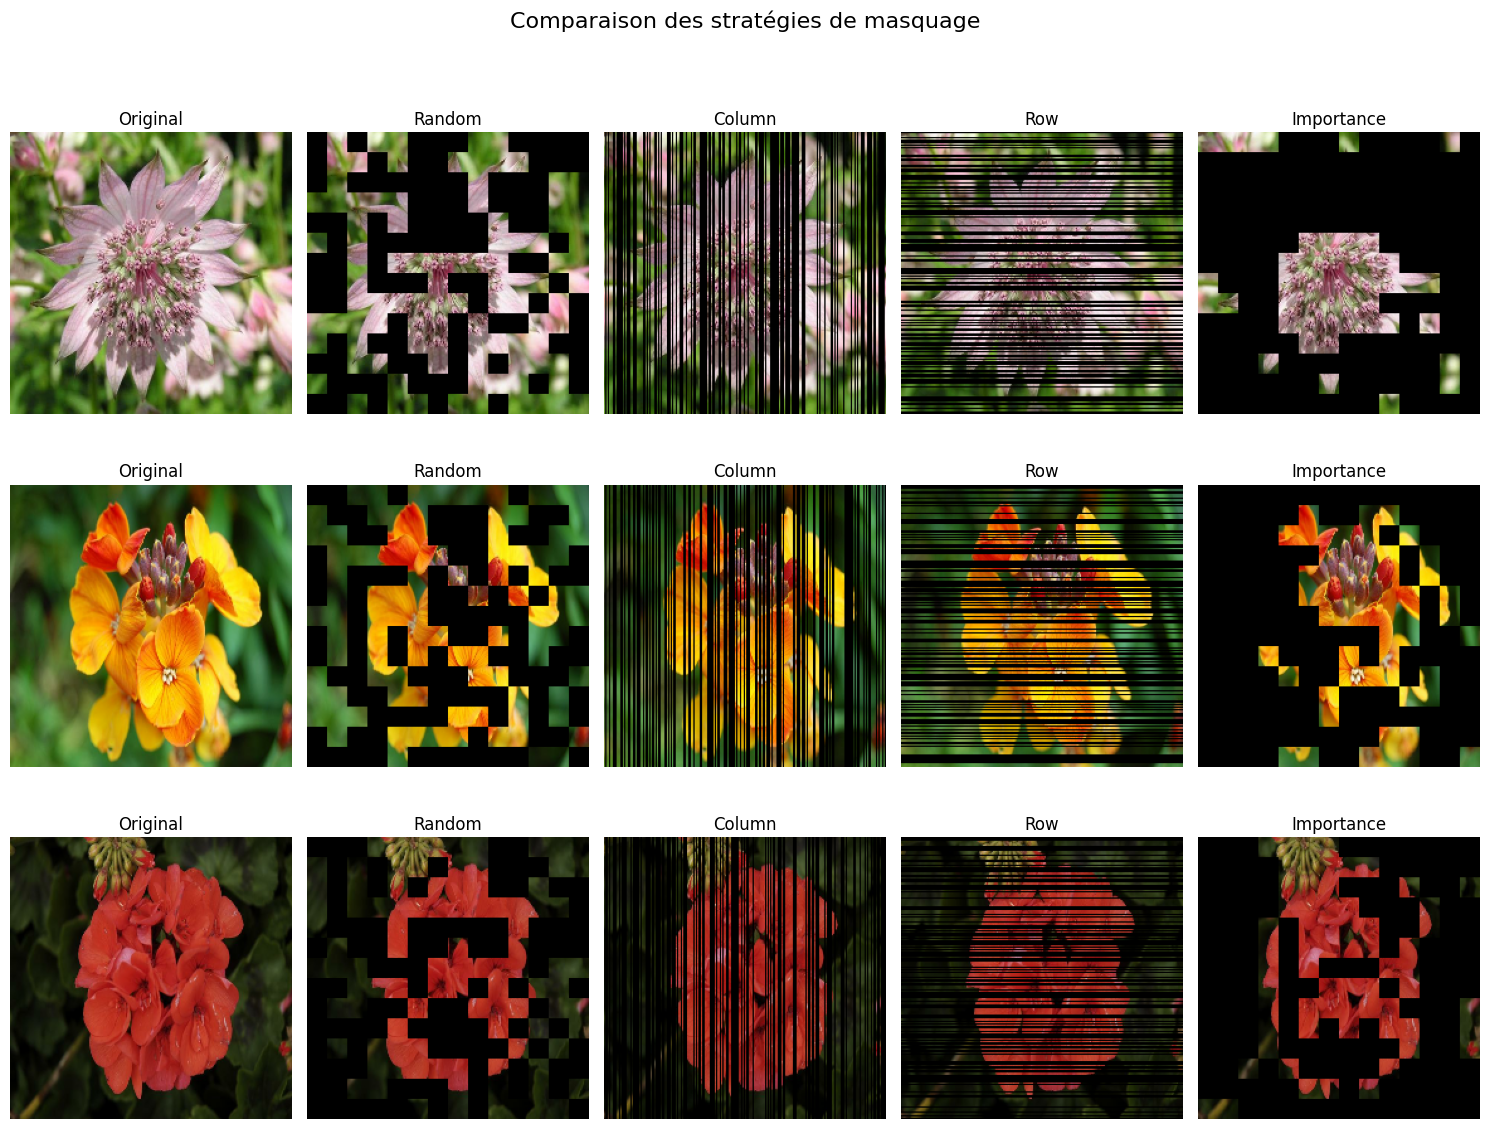

In [9]:
def visualize_masking_strategies(images, strategies):
    num_images = min(3, images.shape[0])
    num_strategies = len(strategies)

    plt.figure(figsize=(15, 4 * num_images))

    for img_idx in range(num_images):
        plt.subplot(num_images, num_strategies + 1, img_idx * (num_strategies + 1) + 1)
        plt.imshow(images[img_idx].numpy())
        plt.title("Original")
        plt.axis('off')

        for i, (name, func) in enumerate(strategies.items()):
            masked_img, _ = func(tf.expand_dims(images[img_idx], 0), masking_ratio=0.5)
            plt.subplot(num_images, num_strategies + 1, img_idx * (num_strategies + 1) + i + 2)
            plt.imshow(masked_img[0].numpy())
            plt.title(name)
            plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Comparaison des stratégies de masquage", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()


# Exemple : images à visualiser depuis val_ds
sample_images = next(iter(val_ds.unbatch().batch(5)))[0]

masking_strategies = {
    "Random": lambda x, masking_ratio=0.5: random_masking(x, masking_ratio),
    "Column": lambda x, masking_ratio=0.5: column_masking(x, masking_ratio),
    "Row": lambda x, masking_ratio=0.5: row_masking(x, masking_ratio),
    "Importance": lambda x, masking_ratio=0.5: importance_masking(x, masking_ratio)
}

visualize_masking_strategies(sample_images, masking_strategies)

# Adaptation du modèle ViT pour la reconstruction

In [10]:
def create_vit_reconstruction_model():
    """
    Crée un modèle de reconstruction d'images basé sur ViT.

    Architecture:
    1. ViT préentraîné pour l'encodage des patchs d'image masquée
    2. Couches de décodage pour reconstruire l'image originale
    
    Avec une fonction de perte focalisée sur les zones masquées.

    Retourne:
        model: Le modèle TensorFlow compilé
    """
    print("Chargement du modèle ViT préentraîné...")

    # Entrée: image masquée
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # NOTE: Nous n'avons pas besoin d'une entrée supplémentaire pour le masque
    # car nous allons l'intégrer dans la fonction de perte

    # Créer une couche personnalisée (au lieu d'utiliser Lambda) qui encapsule le ViT
    class ViTFeatureExtractor(tf.keras.layers.Layer):
        def __init__(self):
          super(ViTFeatureExtractor, self).__init__()
          self.vit = TFViTModel.from_pretrained(
               "google/vit-base-patch16-224",
            from_pt=True
        )

        def call(self, inputs):
            # Le ViT attend un format [batch, channels, height, width], donc on permute les axes de l'image RGB
            inputs_channels_first = tf.transpose(inputs, perm=[0, 3, 1, 2])
            # forward pass through the Vision Transformer, but: groups it under a named scope "vit_forward"
            with tf.name_scope('vit_forward'):
                outputs = self.vit({"pixel_values": inputs_channels_first}, training=False) # training=False : on ne modifie pas les poids (mode évaluation)

            return outputs.last_hidden_state

        def compute_output_shape(self, input_shape):
            batch_size = input_shape[0]
            return (batch_size, 197, 768) #  Le ViT retourne 197 vecteurs ([CLS] + 14×14 = 196 patchs), chacun de dimension 768.

    # Utiliser notre extracteur de caractéristiques ViT
    vit_extractor = ViTFeatureExtractor()
    vit_outputs = vit_extractor(inputs)

    # Reste de l'architecture comme avant...
    # Suppression du token [CLS] (le premier token)
    class RemoveClsToken(tf.keras.layers.Layer):
        def call(self, inputs):
            return inputs[:, 1:, :]

        def compute_output_shape(self, input_shape):
            return (input_shape[0], input_shape[1] - 1, input_shape[2])

    x = RemoveClsToken()(vit_outputs)

    # Reshape pour obtenir une représentation spatiale
    PATCH_SIZE = 16  # Taille des patchs pour ViT-Base
    num_patches_side = IMAGE_SIZE // PATCH_SIZE
    hidden_dim = 768  # Dimension cachée standard de ViT-Base

    # Reshape en représentation spatiale [B, √num_patches, √num_patches, hidden_dim]
    x = tf.keras.layers.Reshape((num_patches_side, num_patches_side, hidden_dim))(x)

    # Décodeur: série de couches de convolution transposée
    # reconstruire l'image avec des Conv2DTranspose
    # 14×14 → 28×28
    x = tf.keras.layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # 28×28 → 56×56
    x = tf.keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # 56×56 → 112×112
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # 112×112 → 224×224
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

   # Couche finale
    outputs = tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)
    
    # Création du modèle
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    def masked_mse_loss(y_true, y_pred):
    # Calculate MSE per pixel
        pixel_mse = tf.square(y_true - y_pred)
    
    # Get batch size and image dimensions
        batch_size = tf.shape(y_true)[0]
        h, w = IMAGE_SIZE, IMAGE_SIZE
        mask_weight = 5.0
    
    # Create importance mask
        y = tf.range(h, dtype=tf.float32)
        x = tf.range(w, dtype=tf.float32)
        center_y, center_x = h / 2, w / 2
        y = tf.expand_dims(y, 1)
        x = tf.expand_dims(x, 0)
    
        y_dist = tf.abs(y - center_y) / (h / 2)
        x_dist = tf.abs(x - center_x) / (w / 2)
        dist = tf.sqrt(tf.square(y_dist) + tf.square(x_dist))
    
    # Create importance mask (higher weight near center)
        importance = 1.0 - tf.clip_by_value(dist, 0, 1)
    
    # Expand importance to [1, h, w, 1]
        importance = tf.expand_dims(tf.expand_dims(importance, 0), -1)
    
    # Tile to match batch size [batch_size, h, w, 1]
        importance = tf.tile(importance, [batch_size, 1, 1, 1])
    
    # Calculate weight factor for each pixel
        weight_factor = 1.0 + (mask_weight - 1.0) * importance
    
    # Apply weights to the pixel-wise MSE
        weighted_pixel_mse = pixel_mse * weight_factor
    
    # Return mean across all dimensions
        return tf.reduce_mean(weighted_pixel_mse)
    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=masked_mse_loss,
        metrics=['mae', 'mse']
    )
    
    return model

# Préparation des données pour l'entraînement avec masquage

In [11]:
class OptimizedMaskingDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, masking_function, batch_size=32, buffer_size=4):
        super().__init__()  # Important: ajout de l'appel au constructeur parent
        self.dataset = dataset
        self.masking_function = masking_function
        self.batch_size = batch_size
        self.buffer_size = min(buffer_size, 8)
        self.batches = list(self.dataset)
        self.length = len(self.batches)
        self.buffer = {}
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if idx in self.buffer:
            return self.buffer[idx]
        
        original_images, _ = self.batches[idx]
        masked_images, masks = self.masking_function(original_images)
        
        if len(self.buffer) >= self.buffer_size:
            oldest_key = next(iter(self.buffer))
            del self.buffer[oldest_key]
        
        # Important: Assurez-vous que le format retourné est correct
        # Pour un modèle standard avec une entrée et une sortie:
        result = (masked_images, original_images)
        self.buffer[idx] = result
        return result
    
    def on_epoch_end(self):
        self.buffer = {}

# Fonctions d'entraînement, d'évaluation et de visualisation

In [12]:
'''def evaluate_reconstruction(model, images, masking_function):
    """
    Évalue la qualité de reconstruction et calcule les métriques.

    Arguments:
        model: Modèle entraîné
        images: Batch d'images à évaluer
        masking_function: Fonction de masquage à appliquer

    Retourne:
        metrics: Dictionnaire de métriques (MSE, SSIM)
    """
    # Appliquer le masquage
    masked_images, masks = masking_function(images)

    # Prédire les reconstructions
    reconstructed_images = model.predict(masked_images)

    # Calculer MSE
    mse = tf.reduce_mean(tf.square(images - reconstructed_images))

    # Calculer SSIM (mesure de similarité structurelle)
    # Implémentation TensorFlow du SSIM
    ssim_values = []
    for i in range(len(images)):
        ssim_value = tf.image.ssim(
            images[i:i+1],
            reconstructed_images[i:i+1],
            max_val=1.0
        )
        ssim_values.append(ssim_value)
    avg_ssim = tf.reduce_mean(ssim_values)

    return {
        'mse': mse.numpy(),
        'ssim': avg_ssim.numpy()
    }
'''

'def evaluate_reconstruction(model, images, masking_function):\n    """\n    Évalue la qualité de reconstruction et calcule les métriques.\n\n    Arguments:\n        model: Modèle entraîné\n        images: Batch d\'images à évaluer\n        masking_function: Fonction de masquage à appliquer\n\n    Retourne:\n        metrics: Dictionnaire de métriques (MSE, SSIM)\n    """\n    # Appliquer le masquage\n    masked_images, masks = masking_function(images)\n\n    # Prédire les reconstructions\n    reconstructed_images = model.predict(masked_images)\n\n    # Calculer MSE\n    mse = tf.reduce_mean(tf.square(images - reconstructed_images))\n\n    # Calculer SSIM (mesure de similarité structurelle)\n    # Implémentation TensorFlow du SSIM\n    ssim_values = []\n    for i in range(len(images)):\n        ssim_value = tf.image.ssim(\n            images[i:i+1],\n            reconstructed_images[i:i+1],\n            max_val=1.0\n        )\n        ssim_values.append(ssim_value)\n    avg_ssim = tf.re

In [13]:
def evaluate_reconstruction(model, images, masking_function):
    """
    Évalue la qualité de reconstruction en combinant les patchs visibles originaux 
    avec les patchs masqués prédits.
    """
    # Appliquer le masquage
    masked_images, masks = masking_function(images)
    
    # Prédire les reconstructions
    predicted_images = model.predict(masked_images)
    
    # Combiner les patchs visibles originaux avec les patchs masqués prédits
    # masks est 1 pour les patchs visibles, 0 pour les masqués
    reconstructed_images = masks * masked_images + (1 - masks) * predicted_images
    
    # Calculer MSE
    mse = tf.reduce_mean(tf.square(images - reconstructed_images))
    
    # Calculer SSIM
    ssim_values = []
    for i in range(len(images)):
        ssim_value = tf.image.ssim(
            images[i:i+1],
            reconstructed_images[i:i+1],
            max_val=1.0
        )
        ssim_values.append(ssim_value)
    avg_ssim = tf.reduce_mean(ssim_values)
    
    return {
        'mse': mse.numpy(),
        'ssim': avg_ssim.numpy(),
        'reconstructed_images': reconstructed_images  # Retourner les images reconstruites
    }

In [14]:
def visualize_reconstructions(model, images, masking_function, num_samples=3):
    """
    Visualise les images originales, masquées et reconstruites.

    Arguments:
        model: Modèle entraîné
        images: Batch d'images à visualiser
        masking_function: Fonction de masquage à appliquer
        num_samples: Nombre d'images à visualiser
    """
    # Limiter le nombre d'échantillons
    num_samples = min(num_samples, len(images))
    images = images[:num_samples]

    # Appliquer le masquage
    masked_images, masks = masking_function(images)

    # Générer les prédictions
    predicted_images = model.predict(masked_images, verbose=0)

    # Combiner les patchs visibles originaux avec les patchs masqués prédits
    reconstructed_images = masks * images + (1 - masks) * predicted_images

    # Visualiser
    plt.figure(figsize=(15, 5*num_samples))

    for i in range(num_samples):
        # Image originale
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title("Image originale")
        plt.axis('off')

        # Image masquée
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masked_images[i])
        plt.title("Image masquée")
        plt.axis('off')

        # Image reconstruite
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predicted_images[i])  # Use predicted_images, not reconstructed_images
        plt.title("Image reconstruite")
        plt.axis('off')

        # Calculer et afficher les métriques pour chaque image
        mse = tf.reduce_mean(tf.square(images[i] - predicted_images[i]))
        ssim_val = tf.image.ssim(
            tf.expand_dims(images[i], 0),
            tf.expand_dims(predicted_images[i], 0),
            max_val=1.0
        )
        plt.suptitle(f"MSE: {mse:.4f}, SSIM: {ssim_val[0]:.4f}", y=0.62 + i*0.33)

    plt.tight_layout()
    plt.show()

In [15]:
def train_model_with_visualization(model, train_ds, val_ds, masking_function, epochs=10, masking_name="importance"):
    print(f"\n=== Training with {masking_name} masking ===")

    # Prepare data generators with masking
    train_gen = OptimizedMaskingDataGenerator(train_ds, masking_function, BATCH_SIZE)
    val_gen = OptimizedMaskingDataGenerator(val_ds, masking_function, BATCH_SIZE)

    # Sample validation images for evaluation
    sample_images = next(iter(val_ds))[0][:3]

    # Create directory for checkpoints
    os.makedirs(f"{CHECKPOINT_PATH}/{masking_name}", exist_ok=True)

    # Callback simplifié pour le suivi des métriques
    class MetricCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if epoch % 2 == 0:  # Réduire la fréquence pour éviter de ralentir l'entraînement
                # Apply masking
                masked_images, _ = masking_function(sample_images)
                
                # Generate reconstructions
                reconstructed_images = self.model.predict(masked_images, verbose=0)
                
                # Calculate metrics
                mse_values = []
                ssim_values = []
                
                for i in range(len(sample_images)):
                    mse = tf.reduce_mean(tf.square(sample_images[i] - reconstructed_images[i]))
                    ssim_val = tf.image.ssim(
                        tf.expand_dims(sample_images[i], 0),
                        tf.expand_dims(reconstructed_images[i], 0),
                        max_val=1.0
                    )
                    
                    mse_values.append(mse.numpy())
                    ssim_values.append(ssim_val.numpy()[0])
                
                avg_mse = sum(mse_values) / len(mse_values)
                avg_ssim = sum(ssim_values) / len(ssim_values)
                
                print(f"Epoch {epoch+1} - Sample MSE: {avg_mse:.4f}, Sample SSIM: {avg_ssim:.4f}")
    
    # Callbacks
    callbacks_list = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f"{CHECKPOINT_PATH}/{masking_name}/best_model.keras",
            monitor='val_loss',
            save_best_only=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f"./logs/{masking_name}",
            histogram_freq=1
        ),
        MetricCallback()
    ]

    # Training with mixed precision for speed (on supported hardware)
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("Mixed precision enabled for faster training")
    except:
        print("Mixed precision not available, using default precision")

    # Training
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks_list
    )

    return history

# Fonction principale pour exécuter les expériences

In [16]:
# Modified main function to run just the importance masking experiment
def main_importance_masking():
    """Run only the importance masking experiment with 30% masking ratio"""

    # Create the model
    model = create_vit_reconstruction_model()

    # Set masking ratio
    masking_ratio = 0.3  # 30% masking

    # Define masking function with fixed ratio
    custom_mask_func = lambda x: importance_masking(x, masking_ratio=masking_ratio)

    # Run the experiment
    exp_name = f"importance_{int(masking_ratio*100)}"
    history = train_model_with_visualization(
        model,
        train_ds,
        val_ds,
        custom_mask_func,
        epochs=EPOCHS,
        masking_name=exp_name
    )

    # Evaluate final performance
    test_images = next(iter(val_ds))[0][:5]
    metrics = evaluate_reconstruction(model, test_images, custom_mask_func)

    print("\n=== Final Results ===")
    print(f"Importance Masking (30%): MSE={metrics['mse']:.4f}, SSIM={metrics['ssim']:.4f}")

    # Final visualization
    visualize_reconstructions(model, test_images, custom_mask_func)

    return history, metrics

In [ ]:
# Run the experiment
if __name__ == "__main__":
    # Make sure TensorFlow is optimized
    tf.config.optimizer.set_jit(True)  # Enable XLA where supported

    # For multi-GPU setups, use MirroredStrategy
    try:
        strategy = tf.distribute.MirroredStrategy()
        print(f"Training with {strategy.num_replicas_in_sync} devices")
    except:
        strategy = tf.distribute.get_strategy()

    with strategy.scope():
        main_importance_masking()

Training with 1 devices
Chargement du modèle ViT préentraîné...


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training with importance_30 masking ===
Mixed precision enabled for faster training
Epoch 1/20


I0000 00:00:1745506471.484308     113 service.cc:148] XLA service 0x40b522e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745506471.485015     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745506476.884011     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - loss: 0.1643 - mae: 0.2321 - mse: 0.0799Epoch 1 - Sample MSE: 0.0509, Sample SSIM: 0.2561
231/231 ━━━━━━━━━━━━━━━━━━━━ 220s 828ms/step - loss: 0.1642 - mae: 0.2319 - mse: 0.0798 - val_loss: 0.1033 - val_mae: 0.1825 - val_mse: 0.0483 - learning_rate: 1.0000e-04
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - loss: 0.0917 - mae: 0.1622 - mse: 0.0426